# Ordinal Regression

In [1]:
%run -m ipy_startup
%matplotlib inline
from py_utils import math

In [2]:
# Generate random data to model
np.random.seed(1)
n, n_class, n_var = 100000, 7, 5
#n, n_class, n_var = 10000, 4, 5

X = np.random.randn(n, n_var)

b_act = np.random.randn(n_var)
#b_out = np.sort(np.random.randn(n_class-1))
b_out = np.linspace(-2, 2, n_class-1)
y_logit = np.dot(X, b_act)[:, np.newaxis]
p = y_logit + np.tile(b_out, (n, 1))
p = math.sigmoid(p)
p = np.hstack((np.zeros((n, 1)), p, np.ones((n, 1))))
p = np.diff(p, axis=1)

y_vals = np.arange(1, n_class + 1)
assert len(y_vals) == p.shape[1]

y = np.array([np.random.choice(y_vals, size=1, p=p[i])[0] for i in range(n)])

X.shape, y.shape

((100000, 5), (100000,))

In [3]:
b_out

array([-2. , -1.2, -0.4,  0.4,  1.2,  2. ])

In [4]:
pd.Series(y).value_counts()

7    24750
1    24607
4    10884
3    10725
5    10249
6     9430
2     9355
dtype: int64

In [5]:
from ml.scipy import optimize, models
param_names = ['X{}'.format(i) for i in range(n_var)]
constraints = optimize.ScipyConstraints()
constraints.add_gtez('X0')
constraints.add_gte('X1', 'X2')
constraints.add_gte('X2', 'X3')
constraints.add_gtev('X4', 2.0)

model = (
    models.ScipyOrdinalRegressionModelBuilder()
    .add_linear_params(param_names)
    .add_outcome_intercepts(n_class)
    #.add_constraints(constraints)
    .build()
)


In [6]:
%%time
est = optimize.ScipyRegressor(model, analytical_gradients=True, monitor_gradient=True)
est.fit(X, y)

CPU times: user 38.5 s, sys: 1.93 s, total: 40.4 s
Wall time: 10.2 s


In [7]:
print(est.get_fit_summary())

Optimization converged successfully:

    Success: True
    Status Code: 0
    Message: Optimization terminated successfully.
    Number of iterations: 21
    Number of function evaluations: 27
    Objective Function Value: 1.4222517724394255
    


In [8]:
est.get_gradient_error_history()

array([  2.13261393e-07,              nan,              nan,
                    nan,   5.18250518e-08,   4.03084411e-08,
         3.40477449e-08,   6.66826450e-08,   8.61791269e-08,
         3.74602240e-08,   3.79214060e-08,   4.45606824e-08,
         5.31027217e-08,   3.87425289e-08,   3.56423749e-08,
         9.31529956e-08,   3.66579478e-08,   4.52392888e-08,
         6.40010176e-08,   3.81221749e-08,   5.66465800e-08])

In [9]:
est.fit_

     fun: 1.4222517724394255
     jac: array([  6.36632047e-05,  -1.05471132e-06,  -2.30718990e-05,
        -1.12000899e-04,   1.88384709e-05,  -8.15275279e-05,
         4.29758434e-04,  -7.14170011e-04,  -3.84169495e-04,
         1.02691371e-03,  -2.23954590e-04])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([ 0.68525376, -1.91424263, -0.52717295, -0.46554297,  0.8983579 ,
       -1.99927578, -1.20387624, -0.39294279,  0.40444159,  1.18742902,
        1.98860078])

In [10]:
d_inf = est.inference()
d_inf

{'fit': OrderedDict(), 'linear': OrderedDict([('X0', 0.68525375875989059), ('X1', -1.9142426325070718), ('X2', -0.52717295412115994), ('X3', -0.46554296822189034), ('X4', 0.89835790185709985)]), 'intercepts': OrderedDict([('Outcome:1', -1.9992757802407239), ('Outcome:2', -1.2038762449835325), ('Outcome:3', -0.39294279111468072), ('Outcome:4', 0.40444158905971778), ('Outcome:5', 1.1874290208364162), ('Outcome:6', 1.988600780487179)])}

In [11]:
b_act

array([ 0.6804625 , -1.90674304, -0.52907885, -0.45989862,  0.90816104])

In [12]:
def compare(v_est, v_act):
    plt.scatter(v_est, v_act)
    vmin, vmax = v_act.min(), v_act.max()
    plt.xlim(vmin - .1, vmax + .1)
    plt.ylim(vmin - .1, vmax + .1)

In [13]:
d_inf['linear']

X0    0.685254
X1   -1.914243
X2   -0.527173
X3   -0.465543
X4    0.898358
dtype: float64

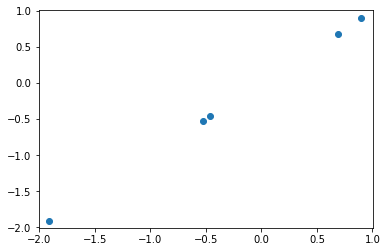

In [14]:
compare(pd.Series(d_inf['linear']), b_act)

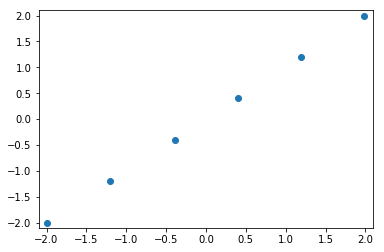

In [15]:
compare(pd.Series(d_inf['intercepts']), b_out)

In [16]:
d_proba = est.predict(X, key='probabilities')
d_proba[:5]

array([[  8.62979435e-01,   7.01421584e-02,   3.60077756e-02,
          1.67232482e-02,   7.63143075e-03,   3.58103389e-03,
          2.93491840e-03],
       [  1.01924898e-03,   1.23592617e-03,   2.80472159e-03,
          6.10280175e-03,   1.29416207e-02,   2.80594829e-02,
          9.47836198e-01],
       [  9.86790774e-01,   7.20304586e-03,   3.32783825e-03,
          1.46995486e-03,   6.55744811e-04,   3.04539172e-04,
          2.48102840e-04],
       [  1.89048688e-01,   1.51510364e-01,   1.96903003e-01,
          1.83152883e-01,   1.28861603e-01,   7.68560699e-02,
          7.36673895e-02],
       [  7.80857146e-03,   9.32734020e-03,   2.06114651e-02,
          4.23535413e-02,   7.99311864e-02,   1.37972593e-01,
          7.01995303e-01]])

In [17]:
pd.Series(np.argmax(d_proba, axis=1) + 1).value_counts()

7    40735
1    39892
4    13577
3     4190
5     1606
dtype: int64

In [18]:
pd.DataFrame({
    'predicted': est.predict(X),
    'actual': y
}).groupby(['predicted', 'actual']).size().unstack().style.background_gradient()

actual,1,2,3,4,5,6,7
predicted,,,,,,,
1,21139,6009,5188,3574,1945,1094,943
3,750,613,814,743,584,341,345
4,1575,1508,2307,2618,2273,1511,1785
5,129,113,235,294,288,235,312
7,1014,1112,2181,3655,5159,6249,21365


In [20]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
pd.DataFrame({
    'predicted': GradientBoostingClassifier().fit(X, y).predict(X),
    'actual': y
}).groupby(['predicted', 'actual']).size().unstack().style.background_gradient()

actual,1,2,3,4,5,6,7
predicted,,,,,,,
1,29029,5466,4519,3242,2017,1143,1004
2,58,183,72,73,63,32,35
3,236,253,596,359,296,215,204
4,228,242,283,624,306,240,240
5,178,147,227,297,464,205,206
6,51,39,91,111,98,198,100
7,971,1098,2043,3284,4440,5538,28956
